## Data Loading

In [26]:
# Extracting Labels
import os
import pandas as pd

gender_map = {0: 'Male', 1: 'Female'}
race_map = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

# Function to Extract Labels
def extract_labels(image_filename):
    try:
        basename = os.path.basename(image_filename)
        name, _ = os.path.splitext(basename)
        labels = name.split('_')
        return {
            'age': int(labels[0]),
            'gender': gender_map.get(int(labels[1]), 'Unknown'),
            'race': race_map.get(int(labels[2]), 'Unknown'),
            'datetime': labels[3]
        }
    except Exception as e:
        print(f"Error extracting labels from {image_filename}: {e}")
        return None

def process_image_folder(folder_path):
    data = []
    for subdir, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".jpg"):
                file_path = os.path.join(subdir, file)
                labels = extract_labels(file_path)
                if labels:
                    labels['image_path'] = file_path
                    data.append(labels)
                else:
                    print(f"Skipping file due to label extraction error: {file_path}")
            else:
                print(f"Skipping non-image file: {file}")

    if data:
        df = pd.DataFrame(data)
    else:
        df = pd.DataFrame(columns=['age', 'gender', 'race', 'datetime', 'image_path'])
    return df

main_folder = "data"
dataframe = process_image_folder(main_folder)

output_csv = 'demographic_features.csv'
dataframe.to_csv(output_csv, index=False)
print(f"Data has been processed and saved to {output_csv}")


Error extracting labels from data\part1\part1\61_1_20170109142408075.jpg: list index out of range
Skipping file due to label extraction error: data\part1\part1\61_1_20170109142408075.jpg
Error extracting labels from data\part1\part1\61_3_20170109150557335.jpg: list index out of range
Skipping file due to label extraction error: data\part1\part1\61_3_20170109150557335.jpg
Error extracting labels from data\part2\part2\39_1_20170116174525125.jpg: list index out of range
Skipping file due to label extraction error: data\part2\part2\39_1_20170116174525125.jpg
Error extracting labels from data\part2\part2\53__0_20170116184028385.jpg: invalid literal for int() with base 10: ''
Skipping file due to label extraction error: data\part2\part2\53__0_20170116184028385.jpg
Skipping non-image file: .DS_Store
Skipping non-image file: 44_1_4_20170116235150272.pg
Skipping non-image file: 55_0_0_20170116232725357jpg
Data has been processed and saved to demographic_features.csv


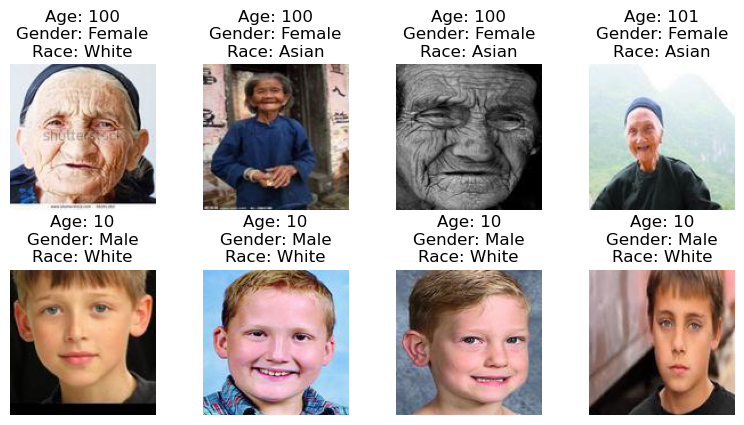

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

df = pd.read_csv("demographic_features.csv")

def display_images_grid(df):
    fig, axs = plt.subplots(2, 4, figsize=(8, 4.5))

    for i, row in df.head(8).iterrows(): 
        img = Image.open(row['image_path'])

        ax = axs[i // 4, i % 4]
        ax.imshow(img)
        ax.axis('off') 
        ax.set_title(f"Age: {row['age']}\nGender: {row['gender']}\nRace: {row['race']}")

    plt.tight_layout(pad=2) 
    plt.show()
display_images_grid(df)

## Data Analysis

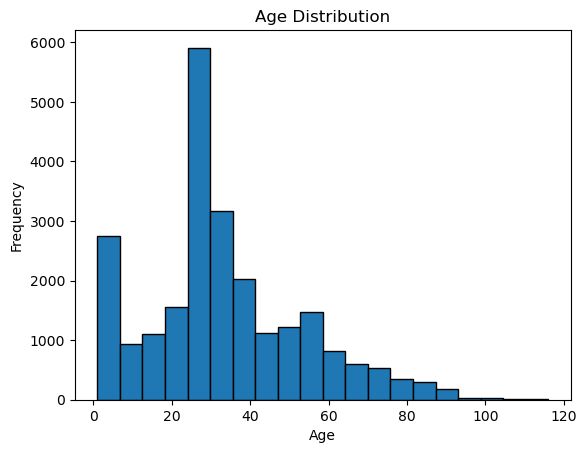

In [28]:
# Ploting age distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.hist(df['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

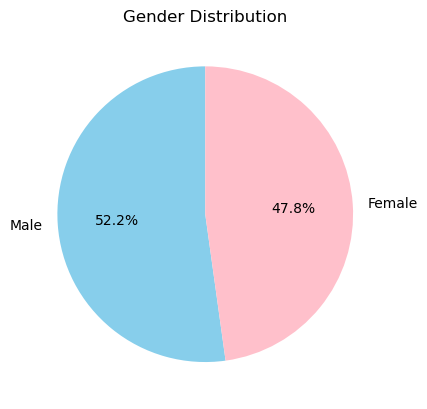

In [29]:
# Ploting Gender Distribution
gender_counts = dataframe['gender'].value_counts()
colors = ['skyblue', 'pink'] 
plt.pie(gender_counts, labels=gender_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.show()

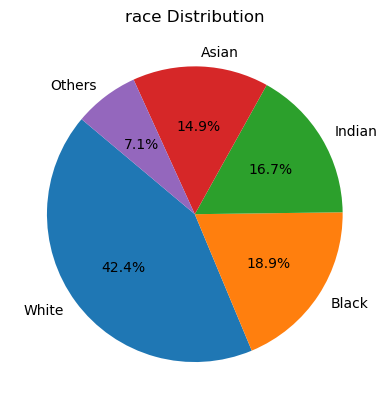

In [30]:
# Ploting Race Destribution
gender_counts = df['race'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('race Distribution')
plt.show()

C:\Users\miraj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


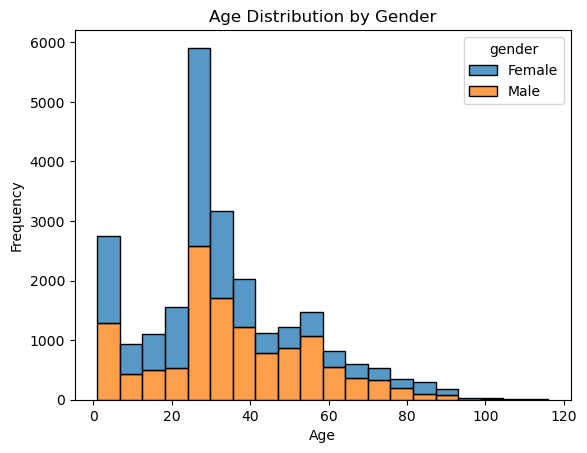

In [31]:
# Ploting Age Distribution by Gender
sns.histplot(df, x='age', hue='gender', multiple='stack', bins=20)
plt.title('Age Distribution by Gender')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

C:\Users\miraj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


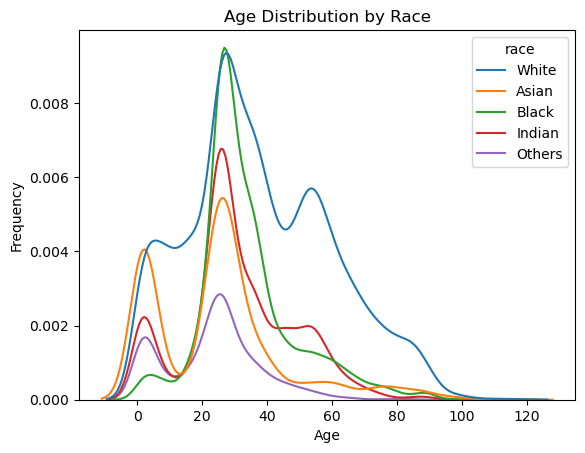

In [32]:
# Age Distribution by Race
sns.kdeplot(df, x='age', hue='race')
plt.title('Age Distribution by Race')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

race    Asian  Black  Indian  Others  White
gender                                     
Female   1942   2221    1742     942   4674
Male     1644   2337    2285     768   5547


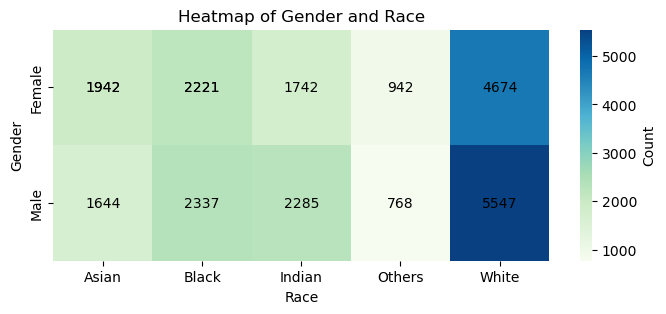

In [33]:
# Plotting Heatmap of Gender and Race
gender_race_pivot = dataframe.pivot_table(index='gender', columns='race', aggfunc='size', fill_value=0)
print(gender_race_pivot)
plt.figure(figsize=(8, 3))
ax = sns.heatmap(gender_race_pivot, annot=True, fmt='d', cmap='GnBu', cbar_kws={'label': 'Count'}, annot_kws={"size": 10, "color": "black"})
plt.title('Heatmap of Gender and Race')
plt.xlabel('Race')
plt.ylabel('Gender')
for y in range(gender_race_pivot.shape[0]):
    for x in range(gender_race_pivot.shape[1]):
        plt.text(x + 0.5, y + 0.5, gender_race_pivot.iloc[y, x], horizontalalignment='center', verticalalignment='center', color='black')
plt.show()

## Data Preproccessing

### Removing data which was not extracted during data Loading in CSV file 

In [34]:
values_to_remove = [
    r'data\part1\part1\16_0_0_20170110231918993.jpg',
    r'data\part1\part1\1_0_0_20170110212603790.jpg',
    r'data\part1\part1\1_0_0_20170110212658392.jpg',
    r'data\part1\part1\56_0_0_20170111202352043.jpg',
    r'data\part1\part1\70_0_0_20170111200757701.jpg',
    r'data\part1\part1\78_0_0_20170111221840478.jpg',
    r'data\part1\part1\80_1_0_20170110131953974.jpg',
    r'data\part1\part1\83_0_0_20170111221828238.jpg',
    r'data\part1\part1\85_0_0_20170111223921971.jpg'
]
df = df[~df['image_path'].isin(values_to_remove)]

In [35]:
df.drop('datetime',axis = 1, inplace = True)

In [36]:
df

,age,gender,race,image_path
0,100,Female,White,data\part1\part1\100_1_0_20170110183726390.jpg
1,100,Female,Asian,data\part1\part1\100_1_2_20170105174847679.jpg
2,100,Female,Asian,data\part1\part1\100_1_2_20170110182836729.jpg
3,101,Female,Asian,data\part1\part1\101_1_2_20170105174739309.jpg
4,10,Male,White,data\part1\part1\10_0_0_20161220222308131.jpg
...,...,...,...,...
24097,99,Female,White,data\part3\part3\99_1_0_20170120134718759.jpg
24098,99,Female,White,data\part3\part3\99_1_0_20170120221920654.jpg
24099,99,Female,Black,data\part3\part3\99_1_1_20170120134639935.jpg
24100,9,Male,White,data\part3\part3\9_0_0_20170120133313910.jpg


In [37]:
import numpy as np
df.replace([np.inf, -np.inf], np.nan).isna().sum().sum()


0

In [38]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Maping 'Male' to 0 and 'Female' to 1
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

# One-hot encode on race
one_hot_encoder = OneHotEncoder(sparse=False)
race_encoded = one_hot_encoder.fit_transform(df[['race']])

race_columns = one_hot_encoder.get_feature_names_out(['race'])
race_df = pd.DataFrame(race_encoded, columns=race_columns)
df = pd.concat([df, race_df], axis=1)

df.drop(['race'], axis=1, inplace=True)


print(df.head())


     age  gender                                      image_path  race_Asian  \
0  100.0     1.0  data\part1\part1\100_1_0_20170110183726390.jpg         0.0   
1  100.0     1.0  data\part1\part1\100_1_2_20170105174847679.jpg         1.0   
2  100.0     1.0  data\part1\part1\100_1_2_20170110182836729.jpg         1.0   
3  101.0     1.0  data\part1\part1\101_1_2_20170105174739309.jpg         1.0   
4   10.0     0.0   data\part1\part1\10_0_0_20161220222308131.jpg         0.0   

   race_Black  race_Indian  race_Others  race_White  
0         0.0          0.0          0.0         1.0  
1         0.0          0.0          0.0         0.0  
2         0.0          0.0          0.0         0.0  
3         0.0          0.0          0.0         0.0  
4         0.0          0.0          0.0         1.0  


C:\Users\miraj\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [39]:
df = df.dropna()

## Modeling